In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
air = pd.read_csv('rsqa-indice-qualite-air-2022-2024.csv')

#Write datetime column
air['heure'] = air['heure'].astype(str).str.zfill(2)
air['corDate'] = air['date'].astype(str) + ' ' + air['heure'].astype(str)
air['DateTime'] = pd.to_datetime(air['corDate'], format='%Y-%m-%d %H')
air = air.drop(['date','heure','corDate'], axis=1)
air.sort_values(by='DateTime', inplace = True)

#Select PM pollutant and station to investigate
PM = air[air['polluant'] == 'PM']
PM3 = PM[PM['stationId'] == 3]

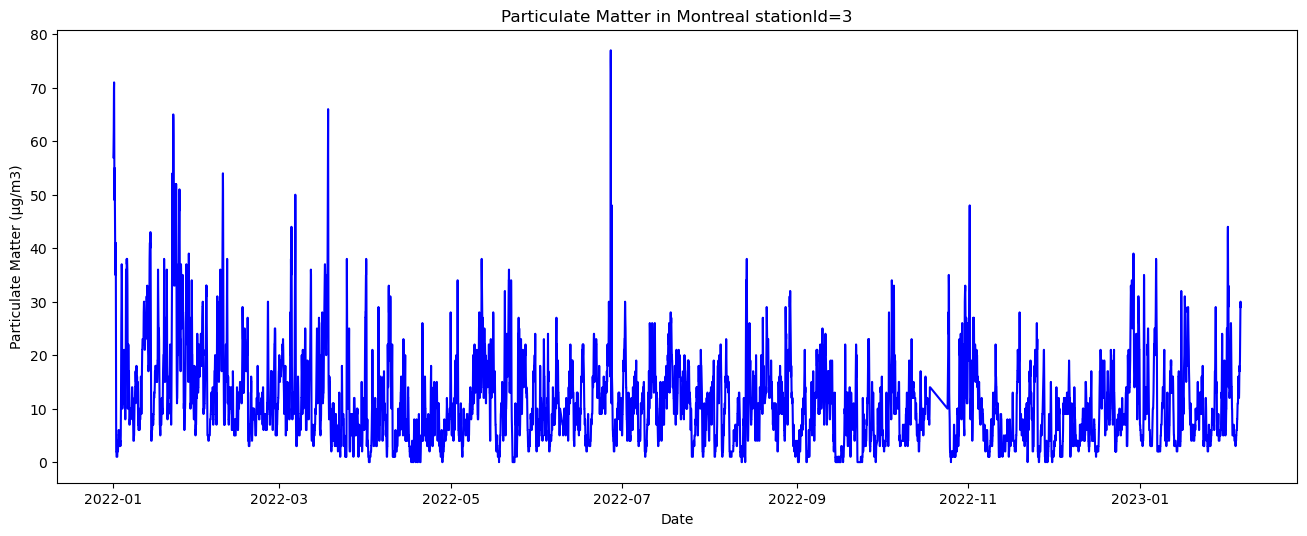

In [29]:
#Plot
def plot_df(df, x, y, title='', xlabel='Date', ylabel='Particulate Matter (µg/m3)', dpi=100, col=''):
    plt.figure(figsize=(16,6), dpi=100)
    plt.plot(x, y, color=col)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(PM3, x = PM3.DateTime, y = PM3.valeur, title = 'Particulate Matter in Montreal stationId=3', col = 'blue')

In [23]:
#Splitting data
train = PM3[PM3.DateTime < pd.to_datetime('2023-01-01', format = '%Y-%m-%d')]
test = PM3[PM3.DateTime > pd.to_datetime('2023-01-01', format = '%Y-%m-%d')]

In [25]:
test

,stationId,polluant,valeur,DateTime
170188,3,PM,11,2023-01-01 01:00:00
170172,3,PM,7,2023-01-01 02:00:00
170152,3,PM,7,2023-01-01 03:00:00
170129,3,PM,7,2023-01-01 04:00:00
170106,3,PM,7,2023-01-01 05:00:00
...,...,...,...,...
277398,3,PM,25,2023-02-05 19:00:00
140064,3,PM,28,2023-02-05 20:00:00
126071,3,PM,29,2023-02-05 21:00:00
118926,3,PM,30,2023-02-05 22:00:00


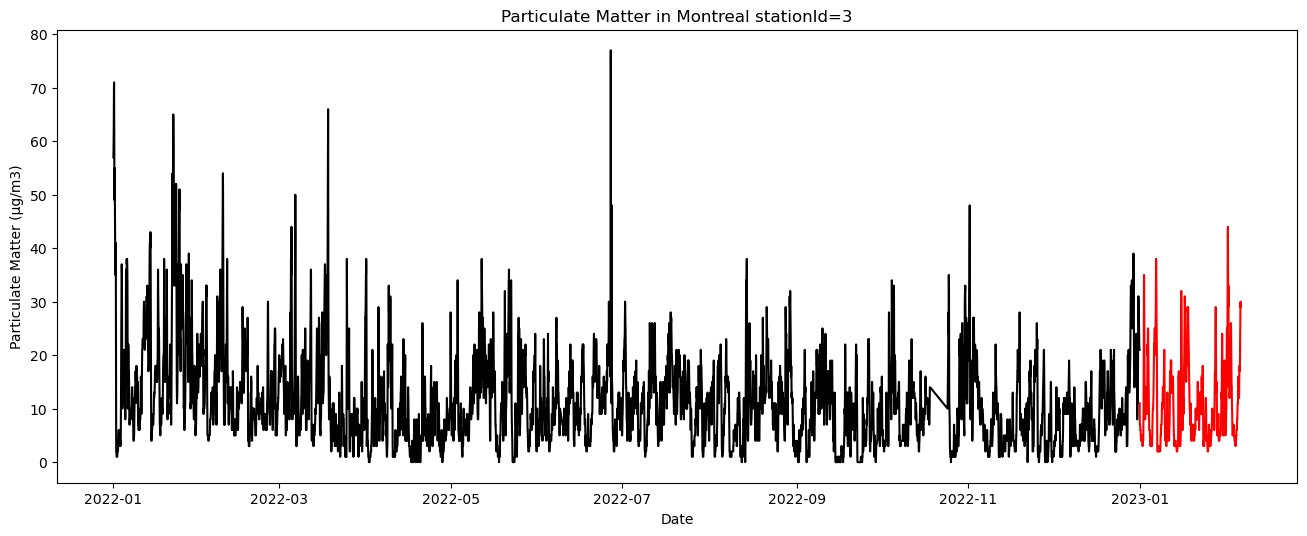

In [35]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(train.DateTime,train.valeur, color = "black")
plt.plot(test.DateTime,test.valeur, color = "red")
plt.gca().set(title='Particulate Matter in Montreal stationId=3', xlabel='Date', ylabel='Particulate Matter (µg/m3)')
plt.show()